# IVI Data Exploration and Cleaning Pipeline

This notebook covers:
1. Loading raw SAS datasets efficiently with Polars + pyreadstat
2. Initial exploration (shape, dtypes, samples)
3. Missing value and outlier analysis
4. **Multi-level data curation:**
   - Contract-level aggregates (for IVI scoring)
   - Member-level features (for detailed analysis)
   - Dimension tables (nationality, provider, diagnosis - for drill-downs)
5. Saving optimized parquet files for downstream analysis

**Design Principles:**
- Use Polars for speed and memory efficiency
- Preserve granularity through multiple aggregation levels
- Create analysis-ready tables for visualizations

In [4]:
# Import Required Libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import multiprocessing

# Fast SAS reading
try:
    import pyreadstat
    USE_PYREADSTAT = True
    print('pyreadstat available - using fast SAS reader')
except ImportError:
    USE_PYREADSTAT = False
    print('pyreadstat not available - install with: pip install pyreadstat')

warnings.filterwarnings('ignore')

# Polars config for better display
pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(20)
pl.Config.set_fmt_str_lengths(50)

# Define paths
DATA_DIR = Path('/volume/data/KAU-Bupa')
OUTPUT_DIR = Path('/volume/data/processed')
CACHE_DIR = Path('/volume/data/cache')

for d in [OUTPUT_DIR, CACHE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

NUM_CORES = multiprocessing.cpu_count()

print(f'Polars version: {pl.__version__}')
print(f'CPU cores available: {NUM_CORES}')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')

pyreadstat available - using fast SAS reader
Polars version: 1.37.1
CPU cores available: 46
Data directory: /volume/data/KAU-Bupa
Output directory: /volume/data/processed


## 1. Data Loading Strategy

**Approach:**
1. Use `pyreadstat.read_file_multiprocessing` for fast SAS reading
2. Convert to Polars LazyFrame immediately
3. Cache as Parquet for instant future loads
4. Use lazy evaluation where possible to minimize memory

In [5]:
def load_sas_to_polars(sas_path: Path, cache_path: Path, name: str, use_cache: bool = True) -> pl.LazyFrame:
    """
    Load SAS file and return as Polars LazyFrame.
    Uses pyreadstat multiprocessing + parquet caching.
    """
    cache_file = cache_path / f'{name}.parquet'
    
    # Check cache first
    if use_cache and cache_file.exists():
        print(f'[{name}] Loading from parquet cache...')
        return pl.scan_parquet(cache_file)
    
    # Read from SAS
    print(f'[{name}] Reading SAS file with {NUM_CORES} cores...')
    
    if USE_PYREADSTAT:
        df_pd, meta = pyreadstat.read_file_multiprocessing(
            pyreadstat.read_sas7bdat,
            str(sas_path),
            num_processes=NUM_CORES
        )
        # Convert to Polars
        df = pl.from_pandas(df_pd)
        del df_pd
        gc.collect()
    else:
        # Fallback: pandas then polars
        df_pd = pd.read_sas(sas_path, encoding='latin1')
        df = pl.from_pandas(df_pd)
        del df_pd
        gc.collect()
    
    print('done reading')
    # Standardize column names
    df = df.rename({col: col.strip().upper() for col in df.columns})
    
    # Decode bytes columns
    for col in df.columns:
        if df[col].dtype == pl.Object:
            df = df.with_columns(
                pl.col(col).map_elements(
                    lambda x: x.decode('latin1') if isinstance(x, bytes) else x,
                    return_dtype=pl.Utf8
                ).alias(col)
            )
    
    print(f'[{name}] Shape: {df.shape}')
    
    # Cache to parquet
    if use_cache:
        print(f'[{name}] Caching to parquet...')
        df.write_parquet(cache_file)
        print(f'[{name}] Cached to: {cache_file}')
        # Return as lazy for memory efficiency
        return pl.scan_parquet(cache_file)
    
    return df.lazy()


print('Loading functions defined.')

Loading functions defined.


In [6]:
# Load all datasets as Polars LazyFrames
print('='*60)
print('LOADING DATASETS')
print('='*60)

lf_member = load_sas_to_polars(DATA_DIR / 'sampled_member.sas7bdat', CACHE_DIR, 'member')
lf_calls = load_sas_to_polars(DATA_DIR / 'sampled_calls.sas7bdat', CACHE_DIR, 'calls')
lf_claims = load_sas_to_polars(DATA_DIR / 'sampled_claims.sas7bdat', CACHE_DIR, 'claims')
lf_preauth = load_sas_to_polars(DATA_DIR / 'sampled_preauth.sas7bdat', CACHE_DIR, 'preauth')

print('\nAll datasets loaded as LazyFrames (memory efficient).')

LOADING DATASETS
[member] Loading from parquet cache...
[calls] Loading from parquet cache...
[claims] Loading from parquet cache...
[preauth] Loading from parquet cache...

All datasets loaded as LazyFrames (memory efficient).


In [7]:
# Load provider reference data (small Excel file)
df_provider = pl.read_excel(DATA_DIR / 'Provider_Info.xlsx')
df_provider = df_provider.rename({col: col.strip().upper() for col in df_provider.columns})

print(f'Provider Info: {df_provider.shape}')
print(f'Columns: {df_provider.columns}')
df_provider.head()

Provider Info: (3558, 6)
Columns: ['PROV_CODE', 'PROV_NAME', 'PROVIDER_NETWORK', 'PROVIDER_PRACTICE', 'PROVIDER_REGION', 'PROVIDER_TOWN']


PROV_CODE,PROV_NAME,PROVIDER_NETWORK,PROVIDER_PRACTICE,PROVIDER_REGION,PROVIDER_TOWN
str,str,str,str,str,str
"""20068""","""Dallah Hospital - Nakeel""","""H. NW7""","""Hospital""","""Central""","""Riyadh"""
"""20134""","""Saudi German Hospitals Group""","""G. NW6""","""Hospital""","""Western""","""Jeddah"""
"""20147""","""United Doctors Hospital""","""F. NW5""","""Hospital""","""Western""","""Jeddah"""
"""22478""","""Oral Dental Clinics""","""J. ONW""","""Dental""","""Western""","""Jeddah"""
"""22671""","""Al Nahdi Medical Company""","""F. NW5""","""Pharmacy""","""Western""","""Jeddah"""


In [8]:
# Quick schema inspection (no data loading - just metadata)
print('DATASET SCHEMAS')
print('='*60)

for name, lf in [('Members', lf_member), ('Calls', lf_calls), 
                  ('Claims', lf_claims), ('Preauth', lf_preauth)]:
    print(f'\n{name}:')
    print(f'  Columns: {lf.collect_schema().names()}')
    print(f'  Types: {dict(lf.collect_schema())}')

DATASET SCHEMAS

Members:
  Columns: ['ADHERENT_NO', 'CONT_YYMM', 'PLAN_ID', 'CONTRACT_NO', 'PLAN_NETWORK', 'GENDER', 'NATIONALITY', 'WE', 'WP']
  Types: {'ADHERENT_NO': String, 'CONT_YYMM': String, 'PLAN_ID': String, 'CONTRACT_NO': String, 'PLAN_NETWORK': String, 'GENDER': String, 'NATIONALITY': String, 'WE': Float64, 'WP': Float64}

Calls:
  Columns: ['CONT_NO', 'CONT_YYMM', 'MBR_NO', 'CALL_ID', 'STATUS', 'CALL_CAT', 'CRT_DATE', 'UPD_DATE']
  Types: {'CONT_NO': String, 'CONT_YYMM': String, 'MBR_NO': String, 'CALL_ID': Float64, 'STATUS': String, 'CALL_CAT': String, 'CRT_DATE': Datetime(time_unit='us', time_zone=None), 'UPD_DATE': Datetime(time_unit='us', time_zone=None)}

Claims:
  Columns: ['ADHERENT_NO', 'PLAN_ID', 'CONT_NO', 'CONT_YYMM', 'VOU_NO', 'LINE_NO', 'PROV_CODE', 'T_PERIOD', 'INCUR_DATE_FROM', 'PROCESS_DATE', 'CLAIM_TYPE', 'DIAG_CODE', 'BEN_HEAD', 'SUBMIT_BY', 'STATUS', 'SUM_OF_NETBILLED']
  Types: {'ADHERENT_NO': String, 'PLAN_ID': String, 'CONT_NO': String, 'CONT_YYMM': S

## 2. Initial Data Exploration

Using Polars lazy evaluation to get statistics without loading full data into memory.

In [9]:
def explore_lazy(lf: pl.LazyFrame, name: str):
    """Explore a LazyFrame with minimal memory usage."""
    print('='*60)
    print(f'Dataset: {name}')
    print('='*60)
    
    # Get row count
    row_count = lf.select(pl.len()).collect().item()
    print(f'Rows: {row_count:,}')
    print(f'Columns: {len(lf.collect_schema())}')
    
    # Sample data
    print('\nSample (5 rows):')
    display(lf.head(5).collect())
    
    # Null counts
    print('\nNull counts:')
    null_counts = lf.null_count().collect()
    display(null_counts)
    
    return row_count

In [10]:
# Explore each dataset
n_members = explore_lazy(lf_member, 'Members')

Dataset: Members
Rows: 4,263,550
Columns: 9

Sample (5 rows):


ADHERENT_NO,CONT_YYMM,PLAN_ID,CONTRACT_NO,PLAN_NETWORK,GENDER,NATIONALITY,WE,WP
str,str,str,str,str,str,str,f64,f64
"""0110058600_0100011213_202201""","""202201""","""0222320""","""0110058600""","""G. NW6""","""F""","""Saudi Arabia""",1.0,20688.822
"""0110058600_0100011312_202201""","""202201""","""0222320""","""0110058600""","""G. NW6""","""F""","""Saudi Arabia""",1.0,20688.822
"""0110058600_0100011320_202201""","""202201""","""0222320""","""0110058600""","""G. NW6""","""M""","""Saudi Arabia""",1.0,20688.822
"""0110058600_0100022210_202201""","""202201""","""0222322""","""0110058600""","""C. NW2""","""F""","""Pakistan""",1.0,10444.357
"""0110058600_0100022319_202201""","""202201""","""0222322""","""0110058600""","""C. NW2""","""F""","""Pakistan""",1.0,10444.357



Null counts:


ADHERENT_NO,CONT_YYMM,PLAN_ID,CONTRACT_NO,PLAN_NETWORK,GENDER,NATIONALITY,WE,WP
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


In [11]:
n_claims = explore_lazy(lf_claims, 'Claims')

Dataset: Claims
Rows: 83,288,467
Columns: 16

Sample (5 rows):


ADHERENT_NO,PLAN_ID,CONT_NO,CONT_YYMM,VOU_NO,LINE_NO,PROV_CODE,T_PERIOD,INCUR_DATE_FROM,PROCESS_DATE,CLAIM_TYPE,DIAG_CODE,BEN_HEAD,SUBMIT_BY,STATUS,SUM_OF_NETBILLED
str,str,str,str,str,f64,str,str,datetime[μs],datetime[μs],str,str,str,str,str,f64
"""0110013300_0100016001_202305""","""0237733""","""0110013300""","""202305""","""01232981625""",1.0,"""22075""","""202306""",2023-06-16 00:00:00,2023-07-05 00:00:00,"""O""","""M79.71""","""Standard Chronic""","""P""","""AC""",36.344
"""0110013300_0100016001_202305""","""0237733""","""0110013300""","""202305""","""01232981625""",2.0,"""22075""","""202306""",2023-06-16 00:00:00,2023-07-05 00:00:00,"""O""","""M79.71""","""Standard Chronic""","""P""","""AC""",6.85993
"""0110013300_0100016001_202305""","""0237733""","""0110013300""","""202305""","""01232981625""",3.0,"""22075""","""202306""",2023-06-16 00:00:00,2023-07-05 00:00:00,"""O""","""M79.71""","""Standard Chronic""","""P""","""AC""",43.6128
"""0110013300_0100016001_202305""","""0237733""","""0110013300""","""202305""","""01232981625""",4.0,"""22075""","""202306""",2023-06-16 00:00:00,2023-07-05 00:00:00,"""O""","""M79.71""","""Standard Chronic""","""P""","""AC""",229.01263
"""0110013300_0100016001_202305""","""0237733""","""0110013300""","""202305""","""01232981625""",5.0,"""22075""","""202306""",2023-06-16 00:00:00,2023-07-05 00:00:00,"""O""","""M79.71""","""Standard Chronic""","""P""","""AC""",77.231



Null counts:


ADHERENT_NO,PLAN_ID,CONT_NO,CONT_YYMM,VOU_NO,LINE_NO,PROV_CODE,T_PERIOD,INCUR_DATE_FROM,PROCESS_DATE,CLAIM_TYPE,DIAG_CODE,BEN_HEAD,SUBMIT_BY,STATUS,SUM_OF_NETBILLED
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
n_calls = explore_lazy(lf_calls, 'Calls')

Dataset: Calls
Rows: 8,920,852
Columns: 8

Sample (5 rows):


CONT_NO,CONT_YYMM,MBR_NO,CALL_ID,STATUS,CALL_CAT,CRT_DATE,UPD_DATE
str,str,str,f64,str,str,datetime[μs],datetime[μs]
"""0144772700""","""202207""","""0100220017""",1.4598664e7,"""C""","""BR""",2018-06-03 10:17:16,2022-07-26 08:40:05
"""0141687800""","""202103""","""01""",1.3728905e7,"""C""","""BO""",2018-01-15 09:52:22,2021-04-26 11:16:40
"""0142979100""","""202107""","""0100067029""",1.4520552e7,"""C""","""RE""",2018-05-20 13:41:58,2021-08-17 09:59:10
"""0144740100""","""202206""","""0100827020""",1.4760342e7,"""C""","""BR""",2018-07-04 15:35:49,2022-07-26 08:39:50
"""0129784600""","""202201""","""0100200014""",1.4356306e7,"""C""","""VP""",2018-04-23 16:40:33,2022-05-18 17:30:44



Null counts:


CONT_NO,CONT_YYMM,MBR_NO,CALL_ID,STATUS,CALL_CAT,CRT_DATE,UPD_DATE
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [13]:
n_preauth = explore_lazy(lf_preauth, 'Preauth')

Dataset: Preauth
Rows: 38,188,288
Columns: 14

Sample (5 rows):


CONT_NO,CONT_YYMM,MBR_NO,PLAN_ID,PREAUTH_EPISODE_ID,PREAUTH_EPISODE_ITEM_ID,TREATMENT_DATE,PROV_CODE,EPISODE_STATUS (STATUS),LINE_STATUS (STATUS),ICD_CODE (DIAG_CODE),BEN_HEAD,REJ_REASON_ID,EST_AMT
str,str,str,str,f64,f64,datetime[μs],str,str,str,str,str,f64,f64
"""0110013300""","""202205""","""0100016327""","""0226865""",7.7879241e7,1.96624054e8,2022-06-21 00:00:00,"""22825""","""C""","""A""","""M54.2""","""C1""",null,331.639
"""0110013300""","""202205""","""0100016327""","""0226865""",7.7879241e7,1.96624055e8,2022-06-21 00:00:00,"""22825""","""C""","""R""","""M79.2""","""C1""",19.0,115.8465
"""0110013300""","""202205""","""0100016327""","""0226865""",7.7879241e7,1.96624056e8,2022-06-21 00:00:00,"""22825""","""C""","""A""","""M54.2""","""C1""",null,104.489
"""0110013300""","""202205""","""0100016327""","""0226865""",7.7879241e7,1.96624057e8,2022-06-21 00:00:00,"""22825""","""C""","""A""","""R51""","""S1""",null,104.489
"""0110013300""","""202205""","""0100016327""","""0226865""",7.793828e7,1.96769569e8,2022-06-22 00:00:00,"""22825""","""C""","""A""","""M79.2""","""C1""",null,115.8465



Null counts:


CONT_NO,CONT_YYMM,MBR_NO,PLAN_ID,PREAUTH_EPISODE_ID,PREAUTH_EPISODE_ITEM_ID,TREATMENT_DATE,PROV_CODE,EPISODE_STATUS (STATUS),LINE_STATUS (STATUS),ICD_CODE (DIAG_CODE),BEN_HEAD,REJ_REASON_ID,EST_AMT
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,27595621,1483


## 3. Key Statistics (Lazy Computation)

In [14]:
# Key statistics computed lazily
print('KEY STATISTICS')
print('='*60)

# Members stats
member_stats = lf_member.select([
    pl.col('ADHERENT_NO').n_unique().alias('unique_members'),
    pl.col('CONTRACT_NO').n_unique().alias('unique_contracts'),
    pl.col('PLAN_ID').n_unique().alias('unique_plans'),
    pl.col('WP').sum().alias('total_premium'),
    pl.col('WE').sum().alias('total_earned'),
]).collect()

print('\nMEMBERS:')
print(f"  Unique members: {member_stats['unique_members'].item():,}")
print(f"  Unique contracts: {member_stats['unique_contracts'].item():,}")
print(f"  Unique plans: {member_stats['unique_plans'].item():,}")
print(f"  Total premium: {member_stats['total_premium'].item():,.0f}")

# Claims stats
claims_stats = lf_claims.select([
    pl.col('ADHERENT_NO').n_unique().alias('unique_members'),
    pl.col('CONT_NO').n_unique().alias('unique_contracts'),
    pl.col('VOU_NO').n_unique().alias('unique_vouchers'),
    pl.col('PROV_CODE').n_unique().alias('unique_providers'),
    pl.col('SUM_OF_NETBILLED').sum().alias('total_billed'),
]).collect()

print('\nCLAIMS:')
print(f"  Unique members: {claims_stats['unique_members'].item():,}")
print(f"  Unique contracts: {claims_stats['unique_contracts'].item():,}")
print(f"  Unique vouchers: {claims_stats['unique_vouchers'].item():,}")
print(f"  Total billed: {claims_stats['total_billed'].item():,.0f}")

KEY STATISTICS



MEMBERS:
  Unique members: 4,201,467
  Unique contracts: 133,704
  Unique plans: 17,074
  Total premium: 69,386,332,785

CLAIMS:
  Unique members: 2,523,830
  Unique contracts: 32,987
  Unique vouchers: 18,386,312
  Total billed: 53,712,680,255


In [15]:
# Calls and Preauth stats
calls_stats = lf_calls.select([
    pl.col('CONT_NO').n_unique().alias('unique_contracts'),
    pl.col('CALL_ID').n_unique().alias('unique_calls'),
    pl.col('MBR_NO').n_unique().alias('unique_members'),
]).collect()

print('CALLS:')
print(f"  Unique contracts: {calls_stats['unique_contracts'].item():,}")
print(f"  Unique calls: {calls_stats['unique_calls'].item():,}")

preauth_stats = lf_preauth.select([
    pl.col('CONT_NO').n_unique().alias('unique_contracts'),
    pl.col('PREAUTH_EPISODE_ID').n_unique().alias('unique_episodes'),
    pl.col('MBR_NO').n_unique().alias('unique_members'),
    pl.col('EST_AMT').sum().alias('total_estimated'),
]).collect()

print('\nPREAUTH:')
print(f"  Unique contracts: {preauth_stats['unique_contracts'].item():,}")
print(f"  Unique episodes: {preauth_stats['unique_episodes'].item():,}")
print(f"  Total estimated: {preauth_stats['total_estimated'].item():,.0f}")

CALLS:
  Unique contracts: 46,570
  Unique calls: 8,920,852

PREAUTH:
  Unique contracts: 32,573
  Unique episodes: 15,593,968
  Total estimated: 116,400,633,936


## 4. Multi-Level Data Aggregation Strategy

We create **three levels** of aggregated data to preserve information:

1. **Contract-Level** - For IVI scoring and corporate client analysis
2. **Member-Level** - For individual health patterns and demographics
3. **Dimension Tables** - For drill-down analysis by nationality, provider, diagnosis, etc.

### 4.1 Contract-Level Aggregation (for IVI)

In [16]:
# Contract-level aggregation from Members
print('Aggregating Members at Contract level...')

agg_member_contract = lf_member.group_by('CONTRACT_NO').agg([
    pl.col('ADHERENT_NO').n_unique().alias('TOTAL_MEMBERS'),
    pl.col('PLAN_ID').n_unique().alias('TOTAL_PLANS'),
    pl.col('WP').sum().alias('TOTAL_WRITTEN_PREMIUM'),
    pl.col('WE').sum().alias('TOTAL_EARNED'),
    pl.col('PLAN_NETWORK').n_unique().alias('UNIQUE_NETWORKS'),
    pl.col('NATIONALITY').n_unique().alias('UNIQUE_NATIONALITIES'),
    # Gender counts
    (pl.col('GENDER') == 'M').sum().alias('MALE_COUNT'),
    (pl.col('GENDER') == 'F').sum().alias('FEMALE_COUNT'),
    # Contract time span
    pl.col('CONT_YYMM').min().alias('CONTRACT_START'),
    pl.col('CONT_YYMM').max().alias('CONTRACT_END'),
]).collect()

print(f'Contract-Member aggregation: {agg_member_contract.shape}')
agg_member_contract.sort(pl.col("UNIQUE_NATIONALITIES"), descending=True).head(15)

Aggregating Members at Contract level...
Contract-Member aggregation: (133704, 11)


CONTRACT_NO,TOTAL_MEMBERS,TOTAL_PLANS,TOTAL_WRITTEN_PREMIUM,TOTAL_EARNED,UNIQUE_NETWORKS,UNIQUE_NATIONALITIES,MALE_COUNT,FEMALE_COUNT,CONTRACT_START,CONTRACT_END
str,u32,u32,f64,f64,u32,u32,u32,u32,str,str
"""0110525300""",11432,13,3.4434e8,9614.11,1,119,5952,5542,"""202211""","""202311"""
"""0132559700""",126485,27,8.4357e9,120805.66,2,95,63369,63133,"""202207""","""202307"""
"""0145914700""",11265,6,1.9405e8,9623.42,2,85,6853,4451,"""202201""","""202301"""
"""0145218500""",5419,6,1.1622e8,3886.69,3,84,3839,1621,"""202201""","""202301"""
"""0150564600""",3995,3,5.5981e7,2943.54,3,84,3038,1048,"""202308""","""202308"""
"""0144579200""",7391,25,3.0026e8,5220.9,2,82,3896,3511,"""202206""","""202306"""
"""0129214100""",21706,10,3.6332e8,19715.49,3,80,12601,9324,"""202201""","""202301"""
"""0149989700""",6059,10,1.0084e8,5075.62,3,77,3422,2815,"""202211""","""202311"""
"""0145854900""",7406,20,9.6397e7,5022.6,6,75,5077,2763,"""202211""","""202311"""


In [17]:
# Contract-level aggregation from Claims
print('Aggregating Claims at Contract level...')

agg_claims_contract = lf_claims.group_by('CONT_NO').agg([
    pl.len().alias('TOTAL_CLAIM_LINES'),
    pl.col('VOU_NO').n_unique().alias('UNIQUE_CLAIMS'),
    pl.col('SUM_OF_NETBILLED').sum().alias('TOTAL_NET_BILLED'),
    pl.col('SUM_OF_NETBILLED').mean().alias('AVG_NET_BILLED'),
    pl.col('SUM_OF_NETBILLED').max().alias('MAX_NET_BILLED'),
    pl.col('SUM_OF_NETBILLED').std().alias('STD_NET_BILLED'),
    pl.col('ADHERENT_NO').n_unique().alias('MEMBERS_WITH_CLAIMS'),
    pl.col('PROV_CODE').n_unique().alias('UNIQUE_PROVIDERS'),
    pl.col('DIAG_CODE').n_unique().alias('UNIQUE_DIAGNOSES'),
    pl.col('BEN_HEAD').n_unique().alias('UNIQUE_BENEFIT_HEADS'),
    # Time features
    pl.col('INCUR_DATE_FROM').min().alias('FIRST_CLAIM_DATE'),
    pl.col('INCUR_DATE_FROM').max().alias('LAST_CLAIM_DATE'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

print(f'Contract-Claims aggregation: {agg_claims_contract.shape}')
agg_claims_contract.head()

Aggregating Claims at Contract level...


Contract-Claims aggregation: (32987, 13)


CONTRACT_NO,TOTAL_CLAIM_LINES,UNIQUE_CLAIMS,TOTAL_NET_BILLED,AVG_NET_BILLED,MAX_NET_BILLED,STD_NET_BILLED,MEMBERS_WITH_CLAIMS,UNIQUE_PROVIDERS,UNIQUE_DIAGNOSES,UNIQUE_BENEFIT_HEADS,FIRST_CLAIM_DATE,LAST_CLAIM_DATE
str,u32,u32,f64,f64,f64,f64,u32,u32,u32,u32,datetime[μs],datetime[μs]
"""0149410900""",166,19,11134.48413,67.075206,605.67276,64.840828,5,2,13,3,2023-01-08 00:00:00,2023-05-29 00:00:00
"""0149727700""",25,20,5568.62768,222.745107,771.49226,261.671273,1,4,10,5,2023-02-12 00:00:00,2023-07-22 00:00:00
"""0149222000""",1520,492,1.3299e6,874.941391,65693.86978,3204.906713,121,67,201,25,2023-01-01 00:00:00,2023-06-04 00:00:00
"""0110297100""",9695,2283,4.5507e6,469.390562,286990.396,3914.729609,411,179,575,54,2023-01-01 00:00:00,2024-04-04 00:00:00
"""0146054400""",10241,2194,3.9417e6,384.898606,267053.25878,3512.265312,438,193,516,37,2023-01-01 00:00:00,2024-02-15 00:00:00


In [18]:
# Contract-level aggregation from Calls
print('Aggregating Calls at Contract level...')

agg_calls_contract = lf_calls.group_by('CONT_NO').agg([
    pl.len().alias('TOTAL_CALLS'),
    pl.col('CALL_ID').n_unique().alias('UNIQUE_CALLS'),
    pl.col('CALL_CAT').n_unique().alias('UNIQUE_CALL_CATEGORIES'),
    pl.col('MBR_NO').n_unique().alias('UNIQUE_CALLERS'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

print(f'Contract-Calls aggregation: {agg_calls_contract.shape}')
agg_calls_contract.head()

Aggregating Calls at Contract level...


Contract-Calls aggregation: (46570, 5)


CONTRACT_NO,TOTAL_CALLS,UNIQUE_CALLS,UNIQUE_CALL_CATEGORIES,UNIQUE_CALLERS
str,u32,u32,u32,u32
"""0155032600""",46,46,5,19
"""0149516100""",1,1,1,1
"""0170382760""",3,3,1,1
"""0150589000""",2,2,2,1
"""0148890700""",3,3,1,1


In [19]:
# Contract-level aggregation from Preauth
print('Aggregating Preauth at Contract level...')

agg_preauth_contract = lf_preauth.group_by('CONT_NO').agg([
    pl.len().alias('TOTAL_PREAUTH_ITEMS'),
    pl.col('PREAUTH_EPISODE_ID').n_unique().alias('UNIQUE_PREAUTH_EPISODES'),
    pl.col('MBR_NO').n_unique().alias('MEMBERS_WITH_PREAUTH'),
    pl.col('EST_AMT').sum().alias('TOTAL_ESTIMATED_AMT'),
    pl.col('EST_AMT').mean().alias('AVG_ESTIMATED_AMT'),
    pl.col('PROV_CODE').n_unique().alias('UNIQUE_PROVIDERS_PREAUTH'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

print(f'Contract-Preauth aggregation: {agg_preauth_contract.shape}')
agg_preauth_contract.head()

Aggregating Preauth at Contract level...


Contract-Preauth aggregation: (32573, 7)


CONTRACT_NO,TOTAL_PREAUTH_ITEMS,UNIQUE_PREAUTH_EPISODES,MEMBERS_WITH_PREAUTH,TOTAL_ESTIMATED_AMT,AVG_ESTIMATED_AMT,UNIQUE_PROVIDERS_PREAUTH
str,u32,u32,u32,f64,f64,u32
"""0149139200""",280,129,14,179167.2883,639.883173,15
"""0149450400""",20,5,1,25304.51,1265.2255,2
"""0146945400""",138,33,4,136366.23154,988.161098,4
"""0150731700""",40,15,2,116127.93885,2903.198471,5
"""0150480700""",2562,1107,212,3.1924e6,1246.048969,143


In [20]:
# Preauth status rates per contract
print('Computing preauth status rates...')

preauth_status_rates = lf_preauth.group_by(['CONT_NO', 'EPISODE_STATUS (STATUS)']).agg([
    pl.len().alias('count')
]).collect().pivot(
    on='EPISODE_STATUS (STATUS)',
    index='CONT_NO',
    values='count'
).fill_null(0)

# Add total and compute rates
status_cols = [c for c in preauth_status_rates.columns if c != 'CONT_NO']
preauth_status_rates = preauth_status_rates.with_columns([
    pl.sum_horizontal(status_cols).alias('TOTAL_STATUS')
])

for col in status_cols:
    preauth_status_rates = preauth_status_rates.with_columns([
        (pl.col(col) / pl.col('TOTAL_STATUS')).alias(f'{col}_RATE')
    ])

preauth_status_rates = preauth_status_rates.rename({'CONT_NO': 'CONTRACT_NO'})
print(f'Preauth status rates: {preauth_status_rates.shape}')
preauth_status_rates.head()

Computing preauth status rates...


Preauth status rates: (32573, 26)


CONTRACT_NO,K,C,R,P,N,A,D,U,T,…,R_RATE,P_RATE,N_RATE,A_RATE,D_RATE,U_RATE,T_RATE,W_RATE,_RATE,H_RATE
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0145971000""",12,433,177,46,16,80,21,62,5,…,0.207746,0.053991,0.018779,0.093897,0.024648,0.07277,0.005869,0.0,0.0,0.0
"""0148053000""",342,2884,829,162,6,202,62,165,0,…,0.178203,0.034824,0.00129,0.043422,0.013328,0.035469,0.0,0.0,0.0,0.0
"""0146982500""",228,6192,1067,664,0,438,105,473,0,…,0.116396,0.072434,0.0,0.04778,0.011454,0.051598,0.0,0.0,0.0,0.0
"""0149342800""",1,15,23,0,0,3,0,0,0,…,0.547619,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0
"""0149895600""",3,114,44,0,0,16,3,5,0,…,0.237838,0.0,0.0,0.086486,0.016216,0.027027,0.0,0.0,0.0,0.0


In [21]:
### 4.2 Member-Level Aggregation (preserves individual patterns)

In [22]:
# Member-level base info (demographics)
print('Creating member-level dataset...')

member_base = lf_member.group_by('ADHERENT_NO').agg([
    pl.col('CONTRACT_NO').first().alias('CONTRACT_NO'),
    pl.col('PLAN_ID').first().alias('PLAN_ID'),
    pl.col('GENDER').first().alias('GENDER'),
    pl.col('NATIONALITY').first().alias('NATIONALITY'),
    pl.col('PLAN_NETWORK').first().alias('PLAN_NETWORK'),
    pl.col('WP').sum().alias('TOTAL_PREMIUM'),
    pl.col('WE').sum().alias('TOTAL_EARNED'),
    pl.col('CONT_YYMM').n_unique().alias('MONTHS_ENROLLED'),
]).collect()

print(f'Member base: {member_base.shape}')
member_base.head()

Creating member-level dataset...


Member base: (4201467, 9)


ADHERENT_NO,CONTRACT_NO,PLAN_ID,GENDER,NATIONALITY,PLAN_NETWORK,TOTAL_PREMIUM,TOTAL_EARNED,MONTHS_ENROLLED
str,str,str,str,str,str,f64,f64,u32
"""0148814500_0100292002_202201""","""0148814500""","""0222791""","""F""","""Saudi Arabia""","""H. NW7""",31433.017,1.0,1
"""0144053600_0102443068_202201""","""0144053600""","""0222938""","""F""","""Saudi Arabia""","""G. NW6""",15228.136,1.0,1
"""0150310700_0100743006_202304""","""0150310700""","""0236275""","""F""","""Saudi Arabia""","""H. NW7""",8156.22962,0.42,1
"""0149408100_0100138001_202205""","""0149408100""","""0224546""","""M""","""Indonesia""","""L. NWS""",1804.0253,0.48,1
"""0147789600_0101324042_202302""","""0147789600""","""0235572""","""F""","""Egypt""","""D. NW3""",8845.221,1.0,1


In [23]:
# Member-level claims aggregation
print('Aggregating claims at member level...')

member_claims = lf_claims.group_by('ADHERENT_NO').agg([
    pl.len().alias('TOTAL_CLAIM_LINES'),
    pl.col('VOU_NO').n_unique().alias('UNIQUE_CLAIMS'),
    pl.col('SUM_OF_NETBILLED').sum().alias('TOTAL_BILLED'),
    pl.col('SUM_OF_NETBILLED').mean().alias('AVG_BILLED'),
    pl.col('SUM_OF_NETBILLED').max().alias('MAX_BILLED'),
    pl.col('PROV_CODE').n_unique().alias('UNIQUE_PROVIDERS'),
    pl.col('DIAG_CODE').n_unique().alias('UNIQUE_DIAGNOSES'),
    pl.col('BEN_HEAD').n_unique().alias('UNIQUE_BENEFITS'),
]).collect()

print(f'Member claims: {member_claims.shape}')
member_claims.head()

Aggregating claims at member level...


Member claims: (2523830, 9)


ADHERENT_NO,TOTAL_CLAIM_LINES,UNIQUE_CLAIMS,TOTAL_BILLED,AVG_BILLED,MAX_BILLED,UNIQUE_PROVIDERS,UNIQUE_DIAGNOSES,UNIQUE_BENEFITS
str,u32,u32,f64,f64,f64,u32,u32,u32
"""0138233900_0107890019_202305""",29,6,14317.12821,493.694076,2380.532,4,6,7
"""0145432200_0102855039_202204""",15,7,1585.46157,105.697438,254.408,3,4,2
"""0150286700_0100195001_202304""",78,15,24517.6624,314.329005,2680.37,7,13,6
"""0127320200_0101328037_202210""",9,2,4741.30195,526.811328,2620.58412,1,2,1
"""0132559700_0105389218_202207""",38,6,23086.11767,607.529412,3180.1,2,9,7


In [24]:
# Merge member-level data
print('Merging member-level datasets...')

df_member_level = member_base.join(
    member_claims, on='ADHERENT_NO', how='left'
).with_columns([
    # Fill nulls for members with no claims
    pl.col('TOTAL_CLAIM_LINES').fill_null(0),
    pl.col('UNIQUE_CLAIMS').fill_null(0),
    pl.col('TOTAL_BILLED').fill_null(0),
    pl.col('AVG_BILLED').fill_null(0),
    pl.col('MAX_BILLED').fill_null(0),
    pl.col('UNIQUE_PROVIDERS').fill_null(0),
    pl.col('UNIQUE_DIAGNOSES').fill_null(0),
    pl.col('UNIQUE_BENEFITS').fill_null(0),
])

# Add derived features
df_member_level = df_member_level.with_columns([
    (pl.col('TOTAL_BILLED') > 0).cast(pl.Int8).alias('IS_UTILIZER'),
    (pl.col('TOTAL_BILLED') / pl.col('TOTAL_EARNED').replace(0, None)).alias('MEMBER_LOSS_RATIO'),
])

print(f'Member-level dataset: {df_member_level.shape}')
df_member_level.head()

Merging member-level datasets...


Member-level dataset: (4201467, 19)


ADHERENT_NO,CONTRACT_NO,PLAN_ID,GENDER,NATIONALITY,PLAN_NETWORK,TOTAL_PREMIUM,TOTAL_EARNED,MONTHS_ENROLLED,TOTAL_CLAIM_LINES,UNIQUE_CLAIMS,TOTAL_BILLED,AVG_BILLED,MAX_BILLED,UNIQUE_PROVIDERS,UNIQUE_DIAGNOSES,UNIQUE_BENEFITS,IS_UTILIZER,MEMBER_LOSS_RATIO
str,str,str,str,str,str,f64,f64,u32,u32,u32,f64,f64,f64,u32,u32,u32,i8,f64
"""0148814500_0100292002_202201""","""0148814500""","""0222791""","""F""","""Saudi Arabia""","""H. NW7""",31433.017,1.0,1,0,0,0.0,0.0,0.0,0,0,0,0,0.0
"""0144053600_0102443068_202201""","""0144053600""","""0222938""","""F""","""Saudi Arabia""","""G. NW6""",15228.136,1.0,1,0,0,0.0,0.0,0.0,0,0,0,0,0.0
"""0150310700_0100743006_202304""","""0150310700""","""0236275""","""F""","""Saudi Arabia""","""H. NW7""",8156.22962,0.42,1,0,0,0.0,0.0,0.0,0,0,0,0,0.0
"""0149408100_0100138001_202205""","""0149408100""","""0224546""","""M""","""Indonesia""","""L. NWS""",1804.0253,0.48,1,12,2,488.3725,40.697708,116.57338,1,2,1,1,1017.442708
"""0147789600_0101324042_202302""","""0147789600""","""0235572""","""F""","""Egypt""","""D. NW3""",8845.221,1.0,1,0,0,0.0,0.0,0.0,0,0,0,0,0.0


### 4.3 Dimension Tables (for drill-down analysis)

In [25]:
# Nationality dimension - claims by nationality per contract
print('Creating nationality dimension table...')

dim_nationality = lf_member.join(
    lf_claims.select(['ADHERENT_NO', 'SUM_OF_NETBILLED']),
    on='ADHERENT_NO',
    how='left'
).group_by(['CONTRACT_NO', 'NATIONALITY']).agg([
    pl.col('ADHERENT_NO').n_unique().alias('MEMBER_COUNT'),
    pl.col('SUM_OF_NETBILLED').sum().alias('TOTAL_BILLED'),
    pl.col('SUM_OF_NETBILLED').mean().alias('AVG_BILLED'),
    pl.col('SUM_OF_NETBILLED').count().alias('CLAIM_COUNT'),
]).collect()

print(f'Nationality dimension: {dim_nationality.shape}')
dim_nationality.head()

Creating nationality dimension table...
Nationality dimension: (281578, 6)


CONTRACT_NO,NATIONALITY,MEMBER_COUNT,TOTAL_BILLED,AVG_BILLED,CLAIM_COUNT
str,str,u32,f64,f64,u32
"""0170717162""","""Uzbekistan""",1,0.0,null,0
"""0149122100""","""Egypt""",7,3175.73872,69.037798,46
"""0145065900""","""Egypt""",3,7010.93932,350.546966,20
"""0150687600""","""Philippines""",19,21743.79746,247.088608,88
"""0156157100""","""Yemen""",2,0.0,null,0


In [26]:
# Provider dimension - claims by provider per contract
print('Creating provider dimension table...')

dim_provider = lf_claims.group_by(['CONT_NO', 'PROV_CODE']).agg([
    pl.col('VOU_NO').n_unique().alias('CLAIM_COUNT'),
    pl.col('SUM_OF_NETBILLED').sum().alias('TOTAL_BILLED'),
    pl.col('SUM_OF_NETBILLED').mean().alias('AVG_BILLED'),
    pl.col('ADHERENT_NO').n_unique().alias('UNIQUE_MEMBERS'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

# Join with provider info
dim_provider = dim_provider.join(
    df_provider.select(['PROV_CODE', 'PROV_NAME', 'PROVIDER_NETWORK', 'PROVIDER_PRACTICE', 'PROVIDER_REGION']),
    on='PROV_CODE',
    how='left'
)

print(f'Provider dimension: {dim_provider.shape}')
dim_provider.head()

Creating provider dimension table...


Provider dimension: (1135632, 10)


CONTRACT_NO,PROV_CODE,CLAIM_COUNT,TOTAL_BILLED,AVG_BILLED,UNIQUE_MEMBERS,PROV_NAME,PROVIDER_NETWORK,PROVIDER_PRACTICE,PROVIDER_REGION
str,str,u32,f64,f64,u32,str,str,str,str
"""0144574700""","""21738""",3,3490.29604,205.311532,2,"""Al Falah International Hospital""","""L. NWS""","""Hospital""","""Central"""
"""0147645300""","""22044""",10,6741.31227,192.608922,2,"""Al Khaleejy Medical Clinic - Al Shefa""","""L. NWS""","""Polyclinic""","""Central"""
"""0150095300""","""21180""",4,1192.03777,47.681511,4,"""Safa Makkah Polyclinic""","""N15""","""Polyclinic""","""Central"""
"""0146491100""","""22160""",3,4579.344,654.192,3,"""Al Bashawri Optical - Dammam""","""L. NWS""","""Optical""","""Eastern"""
"""0110271200""","""23832""",1,188767.23789,20974.137543,1,"""Mohammed Bin Khalifa Bin Sulman Al Khalifa Cardiac…","""I. SPA""","""Cardiac Center""","""Overseas"""


In [27]:
# Diagnosis dimension - top diagnoses per contract
print('Creating diagnosis dimension table...')

dim_diagnosis = lf_claims.group_by(['CONT_NO', 'DIAG_CODE']).agg([
    pl.len().alias('OCCURRENCE_COUNT'),
    pl.col('SUM_OF_NETBILLED').sum().alias('TOTAL_BILLED'),
    pl.col('ADHERENT_NO').n_unique().alias('UNIQUE_MEMBERS'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

print(f'Diagnosis dimension: {dim_diagnosis.shape}')
dim_diagnosis.head()

Creating diagnosis dimension table...


Diagnosis dimension: (3256468, 5)


CONTRACT_NO,DIAG_CODE,OCCURRENCE_COUNT,TOTAL_BILLED,UNIQUE_MEMBERS
str,str,u32,f64,u32
"""0150228400""","""L90.8""",2,137.38032,1
"""0148661800""","""J06""",18,1960.89509,3
"""0147397000""","""D50""",4,150.28244,1
"""0132607400""","""Z32.1""",2,327.096,1
"""0150090300""","""G47.0""",2,116.02822,1


In [28]:
# Call category dimension - call patterns per contract
print('Creating call category dimension table...')

dim_calls = lf_calls.group_by(['CONT_NO', 'CALL_CAT']).agg([
    pl.len().alias('CALL_COUNT'),
    pl.col('MBR_NO').n_unique().alias('UNIQUE_CALLERS'),
]).rename({'CONT_NO': 'CONTRACT_NO'}).collect()

print(f'Call category dimension: {dim_calls.shape}')
dim_calls.head()

Creating call category dimension table...
Call category dimension: (191423, 4)


CONTRACT_NO,CALL_CAT,CALL_COUNT,UNIQUE_CALLERS
str,str,u32,u32
"""0149278200""","""MR""",1,1
"""0146723800""","""CP""",1,1
"""0148126100""","""CP""",1,1
"""0156044300""","""RU""",1,1
"""0125045000""","""CI""",30,1


## 5. Merge Contract-Level Dataset

In [29]:
# Merge all contract-level aggregations
print('Merging contract-level datasets...')

df_contract = agg_member_contract.join(
    agg_claims_contract, on='CONTRACT_NO', how='left'
).join(
    agg_calls_contract, on='CONTRACT_NO', how='left'
).join(
    agg_preauth_contract, on='CONTRACT_NO', how='left'
).join(
    preauth_status_rates.select(['CONTRACT_NO'] + [c for c in preauth_status_rates.columns if '_RATE' in c]),
    on='CONTRACT_NO', how='left'
)

print(f'Merged contract dataset: {df_contract.shape}')
print(f'Columns: {df_contract.columns}')

Merging contract-level datasets...


Merged contract dataset: (133704, 45)
Columns: ['CONTRACT_NO', 'TOTAL_MEMBERS', 'TOTAL_PLANS', 'TOTAL_WRITTEN_PREMIUM', 'TOTAL_EARNED', 'UNIQUE_NETWORKS', 'UNIQUE_NATIONALITIES', 'MALE_COUNT', 'FEMALE_COUNT', 'CONTRACT_START', 'CONTRACT_END', 'TOTAL_CLAIM_LINES', 'UNIQUE_CLAIMS', 'TOTAL_NET_BILLED', 'AVG_NET_BILLED', 'MAX_NET_BILLED', 'STD_NET_BILLED', 'MEMBERS_WITH_CLAIMS', 'UNIQUE_PROVIDERS', 'UNIQUE_DIAGNOSES', 'UNIQUE_BENEFIT_HEADS', 'FIRST_CLAIM_DATE', 'LAST_CLAIM_DATE', 'TOTAL_CALLS', 'UNIQUE_CALLS', 'UNIQUE_CALL_CATEGORIES', 'UNIQUE_CALLERS', 'TOTAL_PREAUTH_ITEMS', 'UNIQUE_PREAUTH_EPISODES', 'MEMBERS_WITH_PREAUTH', 'TOTAL_ESTIMATED_AMT', 'AVG_ESTIMATED_AMT', 'UNIQUE_PROVIDERS_PREAUTH', 'K_RATE', 'C_RATE', 'R_RATE', 'P_RATE', 'N_RATE', 'A_RATE', 'D_RATE', 'U_RATE', 'T_RATE', 'W_RATE', '_RATE', 'H_RATE']


In [30]:
# Fill nulls and add derived features
print('Adding derived features...')

# Fill nulls for contracts with no activity
fill_cols = [c for c in df_contract.columns if c != 'CONTRACT_NO' and df_contract[c].dtype in [pl.Float64, pl.Int64, pl.Int32, pl.Float32]]

df_contract = df_contract.with_columns([
    pl.col(c).fill_null(0) for c in fill_cols
])

# Add IVI-relevant derived features
df_contract = df_contract.with_columns([
    # Utilization metrics
    (pl.col('MEMBERS_WITH_CLAIMS') / pl.col('TOTAL_MEMBERS')).alias('UTILIZATION_RATE'),
    (pl.col('TOTAL_CLAIM_LINES') / pl.col('TOTAL_MEMBERS')).alias('CLAIMS_PER_MEMBER'),
    (pl.col('TOTAL_NET_BILLED') / pl.col('TOTAL_MEMBERS')).alias('COST_PER_MEMBER'),
    (pl.col('TOTAL_NET_BILLED') / pl.col('MEMBERS_WITH_CLAIMS').replace(0, None)).alias('COST_PER_UTILIZER'),
    
    # Loss ratio (key sustainability metric)
    (pl.col('TOTAL_NET_BILLED') / pl.col('TOTAL_EARNED').replace(0, None)).alias('LOSS_RATIO'),
    
    # Experience metrics
    (pl.col('TOTAL_CALLS') / pl.col('TOTAL_MEMBERS')).alias('CALLS_PER_MEMBER'),
    (pl.col('UNIQUE_PREAUTH_EPISODES') / pl.col('TOTAL_MEMBERS')).alias('PREAUTH_PER_MEMBER'),
    
    # Gender ratio
    (pl.col('MALE_COUNT') / pl.col('TOTAL_MEMBERS')).alias('MALE_RATIO'),
    
    # Provider diversity
    (pl.col('UNIQUE_PROVIDERS') / pl.col('MEMBERS_WITH_CLAIMS').replace(0, None)).alias('PROVIDERS_PER_UTILIZER'),
])

# Fill any new nulls
df_contract = df_contract.fill_null(0)

print(f'Final contract dataset: {df_contract.shape}')
df_contract.head()

Adding derived features...
Final contract dataset: (133704, 54)


CONTRACT_NO,TOTAL_MEMBERS,TOTAL_PLANS,TOTAL_WRITTEN_PREMIUM,TOTAL_EARNED,UNIQUE_NETWORKS,UNIQUE_NATIONALITIES,MALE_COUNT,FEMALE_COUNT,CONTRACT_START,…,H_RATE,UTILIZATION_RATE,CLAIMS_PER_MEMBER,COST_PER_MEMBER,COST_PER_UTILIZER,LOSS_RATIO,CALLS_PER_MEMBER,PREAUTH_PER_MEMBER,MALE_RATIO,PROVIDERS_PER_UTILIZER
str,u32,u32,f64,f64,u32,u32,u32,u32,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0170716447""",1,1,711.07036,1.0,1,1,0,1,"""202312""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""0149178700""",4,1,9258.634,4.0,1,3,4,0,"""202203""",…,0.0,0.25,1.75,242.902852,971.61141,242.902852,0.25,4.75,1.0,3.0
"""0170469425""",1,1,711.07036,1.0,1,1,0,1,"""202209""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""0170509617""",1,1,711.07036,1.0,1,1,0,1,"""202211""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""0170582090""",1,1,355.53518,1.0,1,1,0,1,"""202301""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6. Outlier Analysis

In [31]:
def analyze_outliers_polars(df: pl.DataFrame, col: str):
    """Analyze outliers using IQR method with Polars."""
    stats = df.select([
        pl.col(col).quantile(0.25).alias('Q1'),
        pl.col(col).quantile(0.75).alias('Q3'),
        pl.col(col).median().alias('median'),
        pl.col(col).mean().alias('mean'),
    ]).row(0)
    
    Q1, Q3, median, mean = stats
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outlier_count = df.filter(
        (pl.col(col) < lower) | (pl.col(col) > upper)
    ).height
    
    total = df.height
    
    print(f'\n{col} - Outlier Analysis')
    print('-' * 40)
    print(f'Q1: {Q1:,.2f}, Q3: {Q3:,.2f}, IQR: {IQR:,.2f}')
    print(f'Lower bound: {lower:,.2f}, Upper bound: {upper:,.2f}')
    print(f'Outliers: {outlier_count:,} ({outlier_count/total*100:.2f}%)')
    
    return {'Q1': Q1, 'Q3': Q3, 'IQR': IQR, 'lower': lower, 'upper': upper, 'outliers': outlier_count}


# Analyze key metrics
key_metrics = ['TOTAL_NET_BILLED', 'LOSS_RATIO', 'COST_PER_MEMBER', 'UTILIZATION_RATE']

outlier_stats = {}
for metric in key_metrics:
    outlier_stats[metric] = analyze_outliers_polars(df_contract, metric)


TOTAL_NET_BILLED - Outlier Analysis
----------------------------------------
Q1: 0.00, Q3: 0.00, IQR: 0.00
Lower bound: 0.00, Upper bound: 0.00
Outliers: 31,376 (23.47%)

LOSS_RATIO - Outlier Analysis
----------------------------------------
Q1: 0.00, Q3: 0.00, IQR: 0.00
Lower bound: 0.00, Upper bound: 0.00
Outliers: 31,350 (23.45%)

COST_PER_MEMBER - Outlier Analysis
----------------------------------------
Q1: 0.00, Q3: 0.00, IQR: 0.00
Lower bound: 0.00, Upper bound: 0.00
Outliers: 31,376 (23.47%)

UTILIZATION_RATE - Outlier Analysis
----------------------------------------
Q1: 0.00, Q3: 0.00, IQR: 0.00
Lower bound: 0.00, Upper bound: 0.00
Outliers: 31,384 (23.47%)


## 7. Visualizations

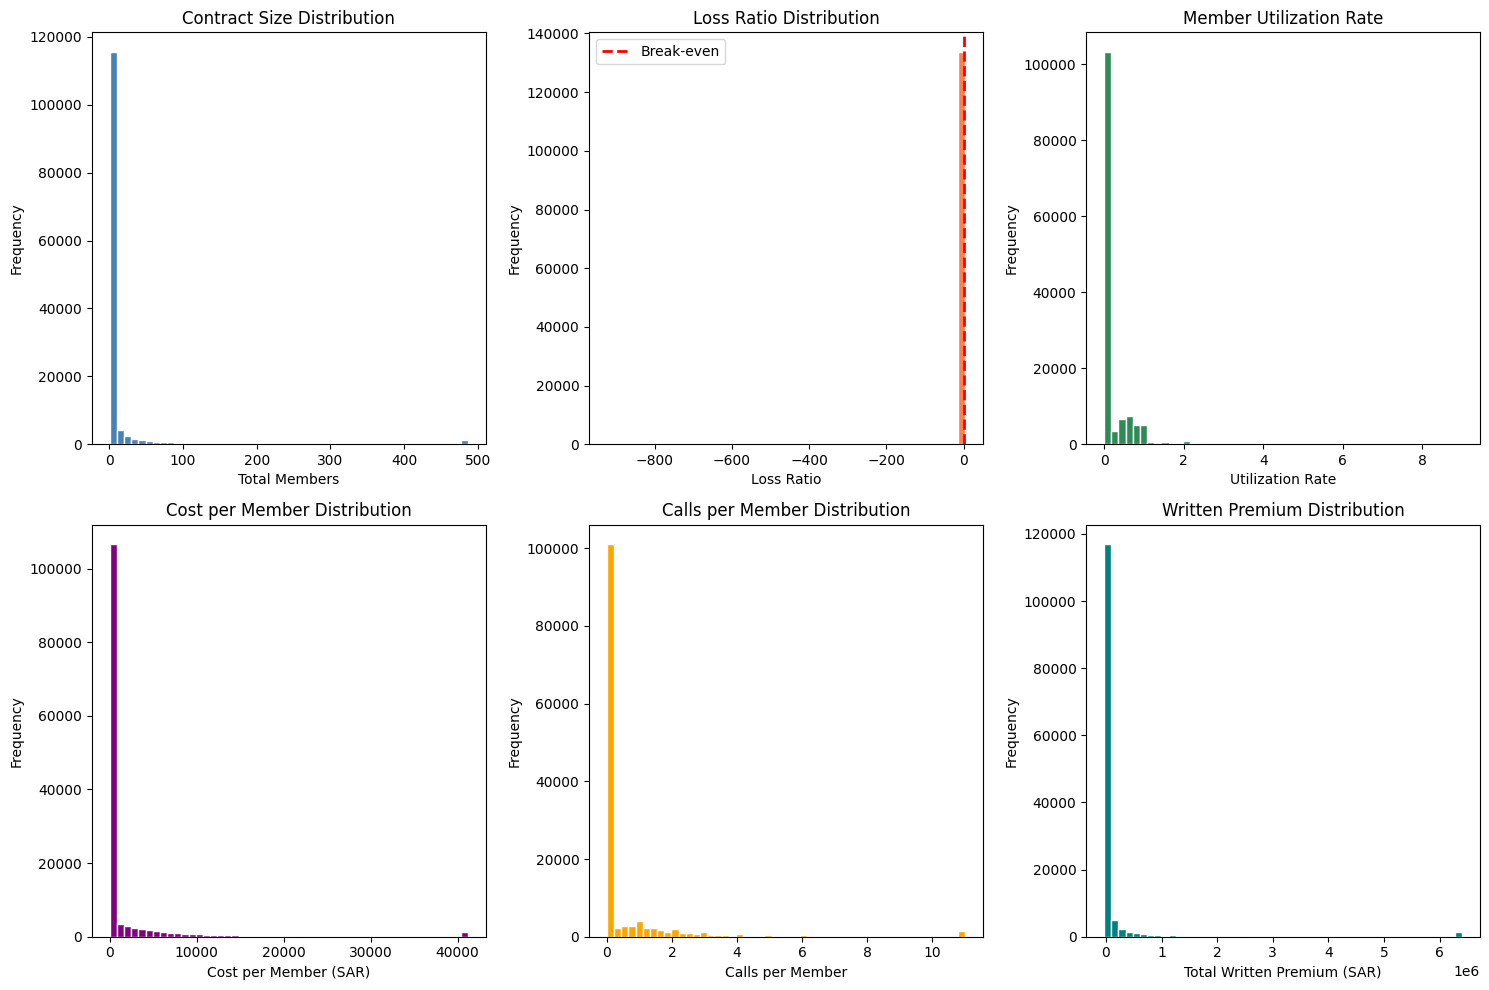

In [32]:
# Convert to pandas for plotting (contract-level is small enough)
df_plot = df_contract.to_pandas()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Contract size distribution
ax = axes[0, 0]
data = df_plot['TOTAL_MEMBERS'].clip(upper=df_plot['TOTAL_MEMBERS'].quantile(0.99))
ax.hist(data, bins=50, color='steelblue', edgecolor='white')
ax.set_xlabel('Total Members')
ax.set_ylabel('Frequency')
ax.set_title('Contract Size Distribution')

# 2. Loss ratio distribution
ax = axes[0, 1]
data = df_plot['LOSS_RATIO'].clip(upper=3)
ax.hist(data, bins=50, color='coral', edgecolor='white')
ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax.set_xlabel('Loss Ratio')
ax.set_ylabel('Frequency')
ax.set_title('Loss Ratio Distribution')
ax.legend()

# 3. Utilization rate
ax = axes[0, 2]
ax.hist(df_plot['UTILIZATION_RATE'], bins=50, color='seagreen', edgecolor='white')
ax.set_xlabel('Utilization Rate')
ax.set_ylabel('Frequency')
ax.set_title('Member Utilization Rate')

# 4. Cost per member
ax = axes[1, 0]
data = df_plot['COST_PER_MEMBER'].clip(upper=df_plot['COST_PER_MEMBER'].quantile(0.99))
ax.hist(data, bins=50, color='purple', edgecolor='white')
ax.set_xlabel('Cost per Member (SAR)')
ax.set_ylabel('Frequency')
ax.set_title('Cost per Member Distribution')

# 5. Calls per member
ax = axes[1, 1]
data = df_plot['CALLS_PER_MEMBER'].clip(upper=df_plot['CALLS_PER_MEMBER'].quantile(0.99))
ax.hist(data, bins=50, color='orange', edgecolor='white')
ax.set_xlabel('Calls per Member')
ax.set_ylabel('Frequency')
ax.set_title('Calls per Member Distribution')

# 6. Written premium
ax = axes[1, 2]
data = df_plot['TOTAL_WRITTEN_PREMIUM'].clip(upper=df_plot['TOTAL_WRITTEN_PREMIUM'].quantile(0.99))
ax.hist(data, bins=50, color='teal', edgecolor='white')
ax.set_xlabel('Total Written Premium (SAR)')
ax.set_ylabel('Frequency')
ax.set_title('Written Premium Distribution')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'contract_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

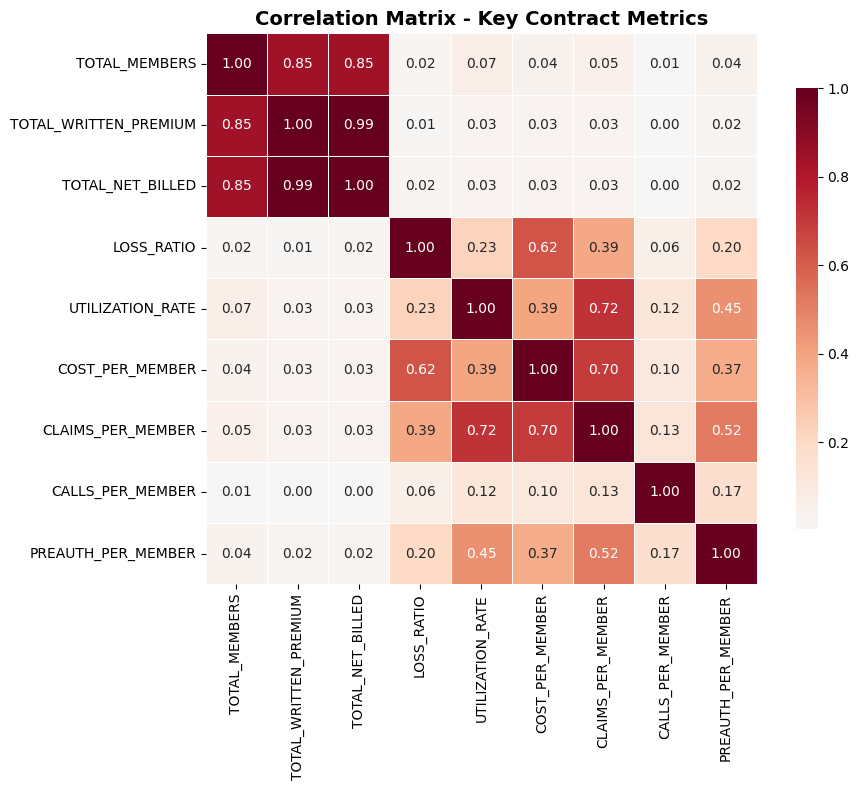

In [33]:
# Correlation heatmap for key IVI metrics
key_metrics = [
    'TOTAL_MEMBERS', 'TOTAL_WRITTEN_PREMIUM', 'TOTAL_NET_BILLED', 'LOSS_RATIO',
    'UTILIZATION_RATE', 'COST_PER_MEMBER', 'CLAIMS_PER_MEMBER', 
    'CALLS_PER_MEMBER', 'PREAUTH_PER_MEMBER'
]

corr_matrix = df_plot[key_metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - Key Contract Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save All Curated Datasets

In [34]:
# Save all curated datasets
print('='*60)
print('SAVING CURATED DATASETS')
print('='*60)

# 1. Contract-level (main IVI dataset)
df_contract.write_parquet(OUTPUT_DIR / 'contract_level.parquet')
print(f'[1] Contract-level: {df_contract.shape} -> contract_level.parquet')

# 2. Member-level (individual analysis)
df_member_level.write_parquet(OUTPUT_DIR / 'member_level.parquet')
print(f'[2] Member-level: {df_member_level.shape} -> member_level.parquet')

# 3. Dimension tables
dim_nationality.write_parquet(OUTPUT_DIR / 'dim_nationality.parquet')
print(f'[3] Nationality dim: {dim_nationality.shape} -> dim_nationality.parquet')

dim_provider.write_parquet(OUTPUT_DIR / 'dim_provider.parquet')
print(f'[4] Provider dim: {dim_provider.shape} -> dim_provider.parquet')

dim_diagnosis.write_parquet(OUTPUT_DIR / 'dim_diagnosis.parquet')
print(f'[5] Diagnosis dim: {dim_diagnosis.shape} -> dim_diagnosis.parquet')

dim_calls.write_parquet(OUTPUT_DIR / 'dim_calls.parquet')
print(f'[6] Calls dim: {dim_calls.shape} -> dim_calls.parquet')

# 4. Provider reference
df_provider.write_parquet(OUTPUT_DIR / 'ref_provider.parquet')
print(f'[7] Provider ref: {df_provider.shape} -> ref_provider.parquet')

print('\n' + '='*60)
print('ALL DATASETS SAVED SUCCESSFULLY')
print('='*60)

SAVING CURATED DATASETS
[1] Contract-level: (133704, 54) -> contract_level.parquet
[2] Member-level: (4201467, 19) -> member_level.parquet
[3] Nationality dim: (281578, 6) -> dim_nationality.parquet
[4] Provider dim: (1135632, 10) -> dim_provider.parquet
[5] Diagnosis dim: (3256468, 5) -> dim_diagnosis.parquet
[6] Calls dim: (191423, 4) -> dim_calls.parquet
[7] Provider ref: (3558, 6) -> ref_provider.parquet

ALL DATASETS SAVED SUCCESSFULLY


In [35]:
# Summary statistics for contract-level data
print('CONTRACT-LEVEL DATASET SUMMARY')
print('='*60)
print(f'Total contracts: {df_contract.height:,}')
print(f'Total features: {df_contract.width}')
print('\nKey Statistics:')
print(df_contract.select([
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('TOTAL_WRITTEN_PREMIUM').sum().alias('Total Premium'),
    pl.col('TOTAL_NET_BILLED').sum().alias('Total Claims'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization'),
]))

print('\nColumn List:')
for i, col in enumerate(df_contract.columns, 1):
    print(f'  {i:2}. {col}')

CONTRACT-LEVEL DATASET SUMMARY
Total contracts: 133,704
Total features: 54

Key Statistics:
shape: (1, 5)
┌───────────────┬───────────────┬──────────────┬────────────────┬─────────────────┐
│ Total Members ┆ Total Premium ┆ Total Claims ┆ Avg Loss Ratio ┆ Avg Utilization │
│ ---           ┆ ---           ┆ ---          ┆ ---            ┆ ---             │
│ u32           ┆ f64           ┆ f64          ┆ f64            ┆ f64             │
╞═══════════════╪═══════════════╪══════════════╪════════════════╪═════════════════╡
│ 4201467       ┆ 6.9386e10     ┆ 5.3669e10    ┆ 3263.436499    ┆ 0.171642        │
└───────────────┴───────────────┴──────────────┴────────────────┴─────────────────┘

Column List:
   1. CONTRACT_NO
   2. TOTAL_MEMBERS
   3. TOTAL_PLANS
   4. TOTAL_WRITTEN_PREMIUM
   5. TOTAL_EARNED
   6. UNIQUE_NETWORKS
   7. UNIQUE_NATIONALITIES
   8. MALE_COUNT
   9. FEMALE_COUNT
  10. CONTRACT_START
  11. CONTRACT_END
  12. TOTAL_CLAIM_LINES
  13. UNIQUE_CLAIMS
  14. TOTAL_NET_BILL

In [36]:
# List all output files with sizes
print('OUTPUT FILES')
print('='*60)
total_size = 0
for f in sorted(OUTPUT_DIR.glob('*.parquet')):
    size_mb = f.stat().st_size / 1e6
    total_size += size_mb
    print(f'  {f.name:35} {size_mb:>8.2f} MB')
print('-'*60)
print(f'  {"TOTAL":35} {total_size:>8.2f} MB')

OUTPUT FILES
  contract_level.parquet                  7.04 MB
  dim_calls.parquet                       1.02 MB
  dim_diagnosis.parquet                  36.09 MB
  dim_nationality.parquet                 3.73 MB
  dim_provider.parquet                   22.60 MB
  member_level.parquet                  125.11 MB
  ref_provider.parquet                    0.06 MB
------------------------------------------------------------
  TOTAL                                 195.66 MB


## 9. Data Access Helper Functions

Use these functions in downstream notebooks for quick data loading.

In [37]:
# Data access functions for downstream notebooks
# Copy these to your analysis notebooks

DATA_PATH = OUTPUT_DIR  # Update path as needed

def load_contract_data() -> pl.DataFrame:
    """Load contract-level data for IVI analysis."""
    return pl.read_parquet(DATA_PATH / 'contract_level.parquet')

def load_member_data() -> pl.DataFrame:
    """Load member-level data for individual analysis."""
    return pl.read_parquet(DATA_PATH / 'member_level.parquet')

def load_dimension(name: str) -> pl.DataFrame:
    """
    Load dimension table for drill-down analysis.
    Options: 'nationality', 'provider', 'diagnosis', 'calls'
    """
    return pl.read_parquet(DATA_PATH / f'dim_{name}.parquet')

def scan_contract_data() -> pl.LazyFrame:
    """Lazy scan for memory-efficient queries on contract data."""
    return pl.scan_parquet(DATA_PATH / 'contract_level.parquet')

def scan_member_data() -> pl.LazyFrame:
    """Lazy scan for memory-efficient queries on member data."""
    return pl.scan_parquet(DATA_PATH / 'member_level.parquet')

print('Data access functions defined.')
print('')
print('Usage examples:')
print('  df = load_contract_data()           # Full contract data')
print('  df = load_member_data()             # Full member data')
print('  df = load_dimension("nationality")  # Nationality drill-down')
print('  lf = scan_contract_data()           # Lazy for large queries')

Data access functions defined.

Usage examples:
  df = load_contract_data()           # Full contract data
  df = load_member_data()             # Full member data
  df = load_dimension("nationality")  # Nationality drill-down
  lf = scan_contract_data()           # Lazy for large queries


## Summary

### Data Processing Pipeline Completed

**Input Data:**
- Members: ~4.3M rows
- Claims: ~86M rows  
- Calls: ~8.9M rows
- Preauth: ~305M rows

**Output Datasets:**

| File | Description | Use Case |
|------|-------------|----------|
| `contract_level.parquet` | Aggregated contract metrics | IVI scoring, corporate analysis |
| `member_level.parquet` | Individual member features | Health patterns, demographics |
| `dim_nationality.parquet` | Claims by nationality | Nationality-based analysis |
| `dim_provider.parquet` | Claims by provider | Provider performance |
| `dim_diagnosis.parquet` | Diagnosis patterns | Health conditions analysis |
| `dim_calls.parquet` | Call patterns | Experience/service analysis |
| `ref_provider.parquet` | Provider reference data | Lookups and joins |

**Key Derived Features:**
- `LOSS_RATIO` - Claims / Earned Premium (sustainability)
- `UTILIZATION_RATE` - Members with claims / Total members
- `COST_PER_MEMBER` - Total billed / Total members
- `CALLS_PER_MEMBER` - Service interaction intensity
- `PREAUTH_PER_MEMBER` - Pre-authorization activity

**Next Steps:**
1. IVI Model Development (use `contract_level.parquet`)
2. Member Health Analysis (use `member_level.parquet`)
3. Drill-down Visualizations (use dimension tables)